In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
import re
import random
import geopandas as gpd
from numba import jit, njit
from shapely import MultiPoint, Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

In [2]:
streetNetwork = gpd.read_file('./Data/streetNetwork.gpkg')
streetNetwork_nodes = gpd.read_file('./Data/streetNetwork_nodes.gpkg')
roadPoints = streetNetwork_nodes['geometry']
roadNodes = MultiPoint(roadPoints)

<h1>CREATE DWELLINGS</h1>

In [3]:
zoneShape = gpd.read_file('Data/TorontoZoneShape/TorontoZones_26917.shp')

In [4]:
zoneData = pd.read_csv('./Data/combinedZoneData.csv')

In [5]:
zoneData.dtypes

DAUID                                    int64
Population                               int64
Employment rate                        float64
Area                                   float64
Total - Structural type of dwelling    float64
dtype: object

In [6]:
dwelling_counts = pd.read_csv('./Data/DwellingTypesByZone2006.csv')

In [52]:
dwellings = pd.DataFrame(columns=['id', 'zone', 'type', 'hhId', 'bedrooms', 'quality', 'monthlyCost', 'restriction', 'yearBuilt', 'floor', 'building', 'usage', 'coordX', 'coordY'])

In [7]:
dwelling_counts = dwelling_counts[dwelling_counts['Geography'].astype(str).isin(zoneData['DAUID'].astype(str))]
dwelling_counts = dwelling_counts.reset_index(drop=True)

zoneShape = zoneShape[zoneShape['DAUID'].isin(zoneData['DAUID'].astype(str))]
zoneShape = zoneShape.reset_index(drop=True)

<Axes: >

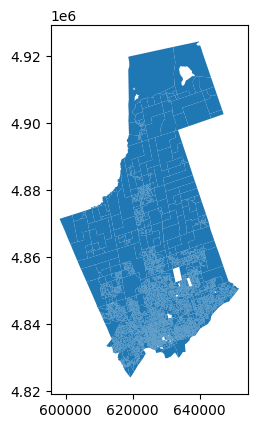

In [8]:
zoneShape.plot()

In [9]:
for i, row in zoneData[~zoneData['DAUID'].astype(str).isin(dwelling_counts['Geography'].astype(str))].iterrows():
    print(row['DAUID'])
    index = len(dwelling_counts)
    dwelling_counts.loc[index, "Geography"] = row['DAUID']
    dwelling_counts.loc[index, "Total - Structural type of dwelling"] = 200

35200545.0
35202819.0
35202840.0
35203156.0
35204130.0


In [27]:
missing_dwelling_counts.shape[0]

5

In [10]:
polygons = []
for i in range(zoneShape.shape[0]):
    polygons.append(zoneShape.iloc[i]['geometry'])
    
geoseries = gpd.GeoSeries(polygons, dwelling_counts['Geography'])
dwelling_coords = geoseries.sample_points(size=dwelling_counts['Total - Structural type of dwelling'].astype(float).astype(int))
dwelling_coords = dwelling_coords.explode(index_parts=True)

In [11]:
total_dwelling_count_GTA = float(dwelling_counts['Total - Structural type of dwelling'].astype(float).sum())
print(total_dwelling_count_GTA)

1252370.0


In [12]:
dwelling_counts.shape[0]

4684

In [13]:
def createDwellings(args:"tuple[int, pd.DataFrame]"):
    num = args[0]
    counts = args[1]
    numRows = 0
    dwellings = pd.DataFrame(columns=['id', 'zone', 'type', 'hhId', 'bedrooms', 'quality', 'monthlyCost', 'restriction', 'yearBuilt', 'floor', 'building', 'usage', 'coordX', 'coordY'])
    dwelling_number = 0
    for i,dwelling in counts.iterrows():
        numDwellings = int(float(dwelling['Total - Structural type of dwelling']))
        for j in range(numDwellings):
            point = Point(float(dwelling_coords[dwelling['Geography']][j].x), float(dwelling_coords[dwelling['Geography']][j].y))
            p1, p2 = nearest_points(point, roadNodes)

            dwellings.loc[len(dwellings)] = [dwelling_number, int(dwelling['Geography']), ['SFD', 'SFA', 'MF234', 'MF5plus', 'MH'][random.randint(0,4)], -1, random.randint(1,4), random.randint(1,4), random.randint(1500,3500), 0, 2006, 1500, 2, -1, p2.x, p2.y]
            dwelling_number+=1
        numRows += 1
        print(numRows,'/1000', dwelling['Geography'])
    
    return dwellings


In [15]:
import threading
class ReturnableThread(threading.Thread):
    # This class is a subclass of Thread that allows the thread to return a value.
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        self.args = args
        threading.Thread.__init__(self, group, target, name, args, kwargs)

        self.target = target
        self.result = None
    
    def run(self) -> None:
        self.result = self.target(self.args)


In [16]:
thread1 = ReturnableThread(target=createDwellings, args=(1, dwelling_counts[:1000]))
thread2 = ReturnableThread(target=createDwellings, args=(2, dwelling_counts[1000:2000]))
thread3 = ReturnableThread(target=createDwellings, args=(3, dwelling_counts[2000:3000]))
thread4 = ReturnableThread(target=createDwellings, args=(4, dwelling_counts[3000:4000]))
thread5 = ReturnableThread(target=createDwellings, args=(5, dwelling_counts[4000:5000]))

thread1.start()
thread2.start()
thread3.start()
thread4.start()
thread5.start()

thread1.join()
thread2.join()
thread3.join()
thread4.join()
thread5.join()

allDwellings = pd.concat([thread1.result, thread2.result, thread3.result, thread4.result, thread5.result])

1 /1000 35190177
1 /1000 35190181
1 /1000 35201179
2 /1000 35190178
1 /1000 35203990
1 /1000 35202553
2 /1000 35201180
3 /1000 35190179
2 /1000 35190182
3 /1000 35201181
4 /1000 35190180
2 /1000 35202554
3 /1000 35190183
4 /1000 35201182
5 /1000 35190783
3 /1000 35202555
2 /1000 35203991
6 /1000 35190784
5 /1000 35201185
4 /1000 35202560
4 /1000 35190184
7 /1000 35190785
6 /1000 35201186
5 /1000 35202564
8 /1000 35190786
7 /1000 35201187
3 /1000 35203992
6 /1000 35202565
9 /1000 35190787
8 /1000 35201188
10 /1000 35190788
9 /1000 35201191
7 /1000 35202566
4 /1000 35203993
10 /1000 35201192
11 /1000 35190789
11 /1000 35201193
8 /1000 35202567
12 /1000 35190790
12 /1000 35201194
13 /1000 35190791
13 /1000 35201195
9 /1000 35202568
14 /1000 35190792
5 /1000 35203994
15 /1000 35191153
14 /1000 35201196
10 /1000 35202569
16 /1000 35191154
15 /1000 35201197
11 /1000 35202570
6 /1000 35203995
17 /1000 35191155
16 /1000 35201198
18 /1000 35191156
12 /1000 35202571
19 /1000 35191157
13 /1000 35

In [17]:
allDwellings.to_csv('./Output/dd_2006.csv', index=False)